# Test on Simulation

In [2]:
from bstpp.main import Hawkes_Model
import numpyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def gen_bg(T):
    centers = np.random.normal(size=10).reshape(5,2)
    n = np.random.poisson(np.random.gamma(150,1,size=5),size=5)
    bg = list()
    for i in range(5):
        bg.append(np.stack((np.random.normal(loc=centers[i,0],size=n[i]),
                                   np.random.normal(loc=centers[i,1],size=n[i]),
                                   np.random.uniform(size=n[i])*T)).T)
    return np.concatenate(bg)

def gen_bg(T,type='norm',X=None):
    n_bg = np.random.poisson(250,size=1)
    if type == 'norm':
        bg = np.stack((np.random.normal(scale=1.5, size=n_bg),
                         np.random.normal(scale=1.5, size=n_bg),
                         np.random.uniform(size=n_bg)*T)).T
    if type == 'unif':
        bg = np.stack((np.random.uniform(-5,5,size=n_bg),
                         np.random.uniform(-5,5,size=n_bg),
                         np.random.uniform(0,T,size=n_bg))).T
    if X is not None:
        sp_int = np.exp(X @ w + 1.5)
        n_bg = np.random.poisson(sp_int,size=len(sp_int))
        unif = np.random.uniform(0,1,size=n_bg.sum()*2).reshape(-1,2)
        n_xy = 25
        grid = np.arange(-5, 5, 1)
        u, v = np.meshgrid(grid, grid)
        x_xy = np.array([u.flatten(), v.flatten()]).transpose((1, 0)).astype(np.float32)
        ind = np.hstack([np.ones(n_bg[i],dtype=int)*i for i in range(len(n_bg))])
        points = x_xy[ind,:]+unif
        points = np.append(points,np.random.uniform(0,T,size=len(points)).reshape(-1,1),axis=1)
        return np.append(bg,points,axis=0)
    else:
        return bg

def gen_dat(par,T):
    r_0, b, sigma_1, sigma_2 = par
    bg = gen_bg(T,type='norm')#,X=X)
    i = 0
    while i < len(bg):
        for j in range(np.random.poisson(lam=r_0)):
            bg = np.concatenate((bg,[bg[i]+[np.random.normal(scale=sigma_1), 
                                           np.random.normal(scale=sigma_2), 
                                           np.random.exponential(b)]]))
        i += 1
    return bg
X = np.random.normal(scale = 1, size=(100,3))
X = (X-X.mean(axis=0))/(X.var(axis=0)**0.5)
w = np.random.normal(size=3,scale=0.75)
par = np.array([.25,1,.1,.1])
events = gen_dat(par,365)
#events = gen_bg(365,type='norm',X=X)
events = events[np.logical_and(abs(events.T[0])<5,abs(events.T[1])<5,events.T[2]<365)]
events = events[events[:, 2].argsort()]
len(events)

323

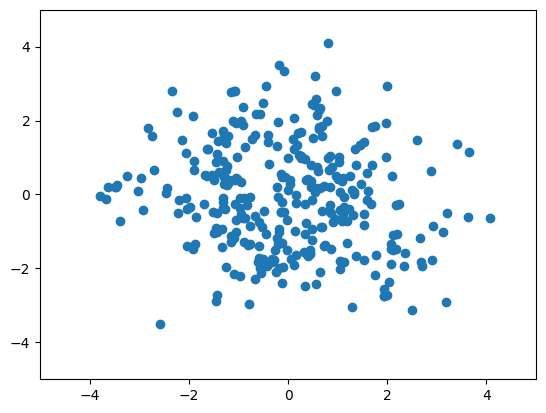

In [4]:
plt.scatter(events.T[0],events.T[1])
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.show()

In [5]:
import pandas as pd
xyt = pd.DataFrame(events,columns=['X','Y','T'])
cov = pd.DataFrame(X)
n_xy = 25
grid = np.arange(-5, 5, 1)
u, v = np.meshgrid(grid, grid)
x_xy = np.array([u.flatten(), v.flatten()]).transpose((1, 0)).astype(np.float32)
cov['X'] = x_xy[:,0]+.5
cov['Y'] = x_xy[:,1]+.5
A = np.array([[-5,5],[-5,5]])

In [10]:
from bstpp.trigger import *
from bstpp.main import LGCP_Model

model = Hawkes_Model(xyt,A,False,
                            #spatial_cov=cov,cov_grid_size=(1,1),
                            #cov_names = np.arange(3),
                            alpha=dist.Beta(5,15),sigmax_2=dist.HalfNormal(.01),
                            w=dist.Normal(np.zeros(3),4*np.ones(3)),a_0=dist.Normal(1,3),
                            beta=dist.HalfNormal(0.2),gamma=dist.HalfNormal(0.2),
                            temporal_trig=Temporal_Power_Law
                           )

In [6]:
model.spatial_cov['sp_int'] =np.exp(X @ w)
ax = model.spatial_cov.plot('sp_int')
model.points.plot(ax=ax,markersize=2,color='red')

AttributeError: 'Point_Process_Model' object has no attribute 'spatial_cov'

In [11]:
model.run_mcmc()

sample: 100%|█████████████████████████████| 1500/1500 [01:56<00:00, 12.90it/s, 3 steps of size 4.87e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_0      1.03      0.10      1.04      0.88      1.20    401.61      1.00
     alpha      0.76      0.05      0.76      0.67      0.84    566.99      1.00
      beta      0.21      0.03      0.21      0.16      0.25    610.96      1.00
     gamma      0.10      0.03      0.10      0.06      0.14    436.48      1.00
  sigmax_2      0.00      0.00      0.00      0.00      0.00    315.46      1.00

Number of divergences: 0

MCMC elapsed time: 122.44170475006104


,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.759181,0.051923,14.621238,0.000000e+00,0.648254,0.851799
beta,0.210142,0.029837,7.042966,1.881939e-12,0.159050,0.279078
gamma,0.099721,0.027753,3.593223,3.266131e-04,0.057861,0.164602
sigmax_2,0.000262,0.000056,4.660962,3.147354e-06,0.000182,0.000397


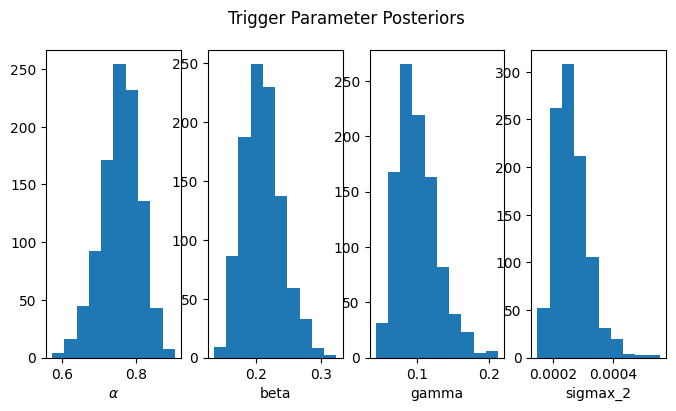

In [13]:
model.plot_trigger_posterior()

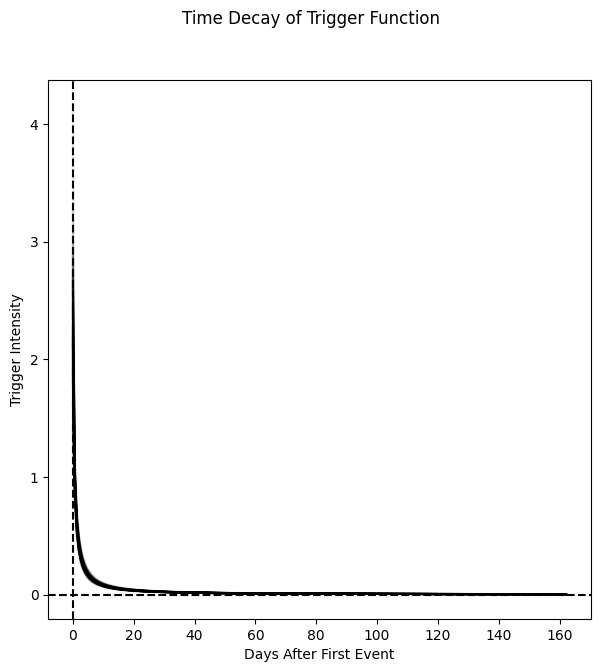

In [12]:
model.plot_trigger_time_decay()

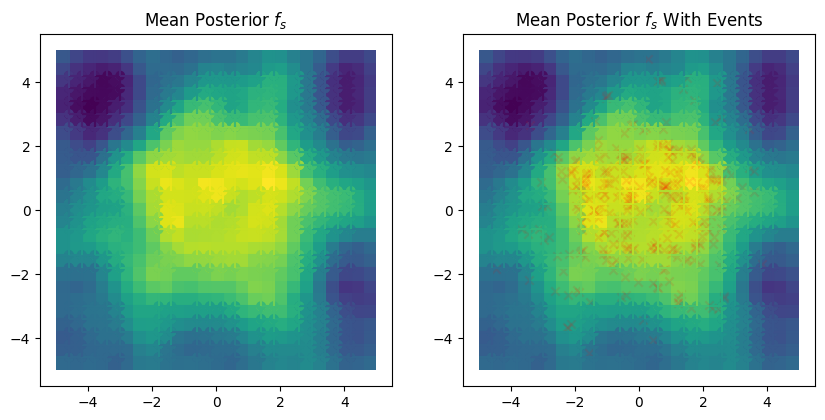

In [7]:
model.plot_spatial()

In [20]:
model.log_expected_likelihood(pd.DataFrame(test_events,columns=['X','Y','T']))

534.2146606445312

In [13]:
test_events = gen_dat(par,365)
test_events = test_events[np.logical_and(abs(test_events.T[0])<5,abs(test_events.T[1])<5,test_events.T[2]<365)]
test_events = test_events[test_events[:, 2].argsort()]
model.log_expected_likelihood(pd.DataFrame(test_events,columns=['X','Y','T']))

440.927490234375

In [413]:
import pickle
output = {'mcmc':model.mcmc,
          'mcmc_samples':model.mcmc_samples,
          'w':w,
          'X':X
         }
with open('output/Simulation/lgcp/output_cov.pkl','wb') as f:
    pickle.dump(output,f)

In [7]:
model.plot_spatial_background(alpha=.25)

Exception: Nothing to plot: spatial background is constant

In [433]:
with open('output/Simulation/Full_Cox_Hawkes/model_no_cov.o','wb') as f:
    pickle.dump(model,f)

In [415]:
model.cov_names = list(model.cov_names)

In [416]:
w

array([0.71895895, 0.61291601, 0.37466281])

In [417]:
from math import ceil
def cov_weight_post_summary(self,vb,plot_file=None,summary_file=None):
    """
    Plot posteriors of weights and bias and save summary of posteriors.
    
    Parameters
    ----------
    plot_file: str
        Path in which to save plot.
    summary_file: str
        Path in which to save summary
    Returns
    -------
    pd.DataFrame
        summary of weights and bias
    """
    if 'mcmc_samples' not in dir(self):
        raise Exception("MCMC posterior sampling has not been performed yet.")
    if 'spatial_cov' not in self.args:
        raise Exception("Spatial covariates were not included in the model.")
    
    n = self.mcmc_samples['w'].shape[1]+1
    c = ceil(n**0.5)
    r = ceil(n/c)
    fig, ax = plt.subplots(r,c,figsize=(10,6), sharex=False)
    #fig.suptitle('Covariate Weights', fontsize=16)
    for i in range(n-1):
        ax[i//c,i%c].hist(self.mcmc_samples['w'].T[i])
        ax[i//c,i%c].axvline(vb[i],color='red')
        ax[i//c,i%c].set_xlabel(self.cov_names[i])
    ax[(n-1)//c,(n-1)%c].hist(self.mcmc_samples['a_0'])
    ax[(n-1)//c,(n-1)%c].set_xlabel("$a_0$")
    if plot_file is not None:
        plt.savefig(plot_file)
    plt.show()

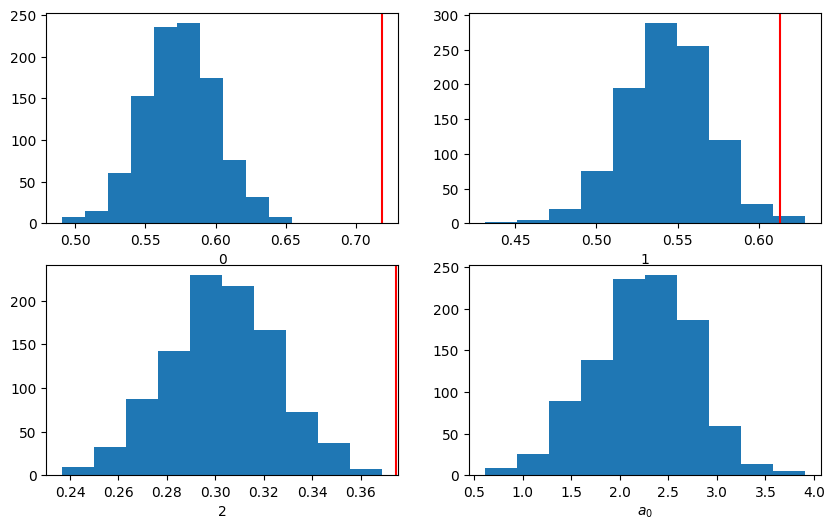

In [418]:
cov_weight_post_summary(model,w)

In [428]:
def plot_trigger_posterior(self,vb,output_file=None):
    """
    Plot histograms of posterior trigger parameters.
    
    Parameters
    ----------
    output_file: str
        Path in which to save plot.
    Returns
    -------
    pd.DataFrame
        Summary of trigger parameters.
    """
    if 'mcmc_samples' not in dir(self):
        raise Exception("MCMC posterior sampling has not been performed yet.")
    if self.args['model'] not in ['hawkes','cox_hawkes']:
        raise Exception("This is not a Hawkes Model. Cannot plot trigger parameters.")
    fig, ax = plt.subplots(1, 3,figsize=(8,4), sharex=False)
    plt.suptitle("Trigger Parameter Posteriors")
    ax[0].hist(self.mcmc_samples['alpha'])
    ax[0].axvline(vb[0],color='red')
    ax[0].set_xlabel(r"${\alpha} $")
    ax[1].hist(self.mcmc_samples['beta'])
    ax[1].axvline(vb[1],color='red')
    ax[1].set_xlabel(r"$\beta$")
    ax[2].hist(self.mcmc_samples['sigmax_2']**0.5)
    ax[2].axvline(vb[2],color='red')
    ax[2].set_xlabel('$\sigma$')
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

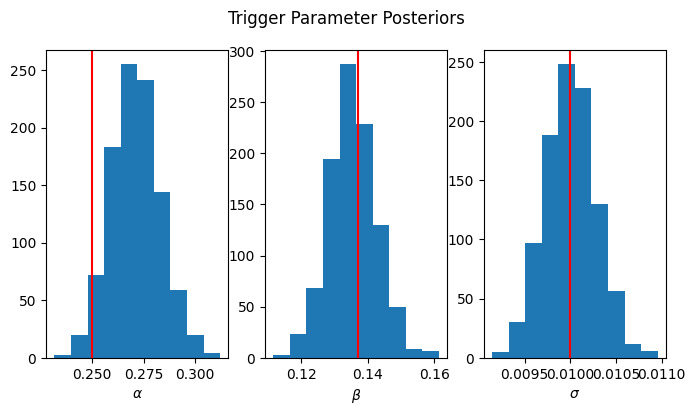

In [429]:
plot_trigger_posterior(model,[0.25,50/365,0.01])

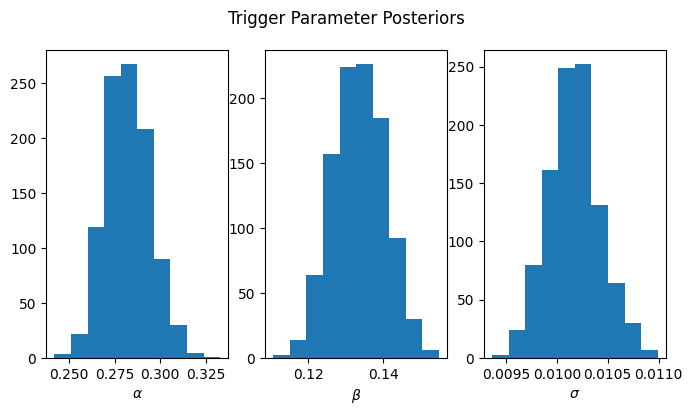

In [41]:
a = model.plot_trigger_posterior()

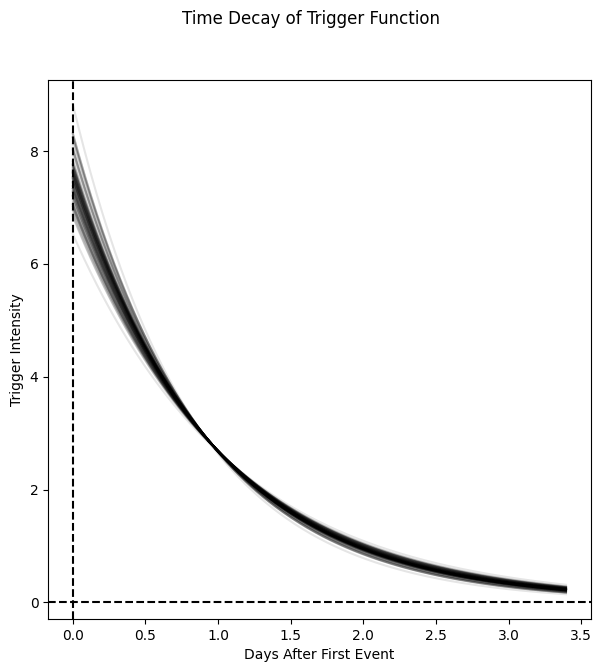

Mean trigger time: 0.97 days


In [42]:
model.plot_trigger_time_decay()

In [43]:
model.plot_temporal_background()

Exception: Nothing to plot: temporal background in constant.

(array([ 25.,  56., 126., 176., 201., 180., 120.,  78.,  28.,  10.]),
 array([1734.6843, 1752.2758, 1769.8673, 1787.4587, 1805.0502, 1822.6416,
        1840.2332, 1857.8246, 1875.416 , 1893.0076, 1910.599 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

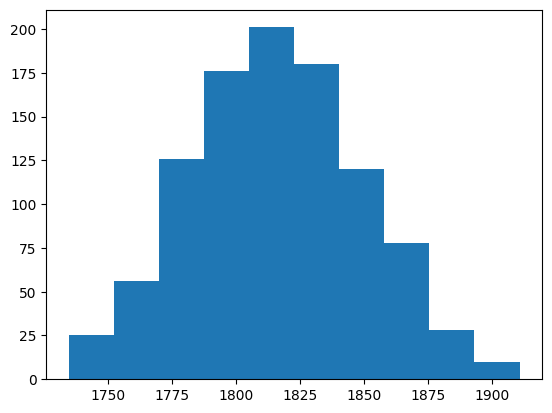

In [128]:
plt.hist(model.mcmc_samples['Itot_txy_back'])

In [15]:
model = Point_Process_Model(xyt,A,'cox_hawkes',
                            alpha=dist.Beta(5,15),beta=dist.HalfNormal(.2),sigmax_2=dist.HalfNormal(.01)
                           )

100%|███████████████████████| 100000/100000 [11:18<00:00, 147.42it/s, init loss: 25664.0723, avg. loss [95001-100000]: -8034.0063]



SVI elapsed time: 699.5545551776886


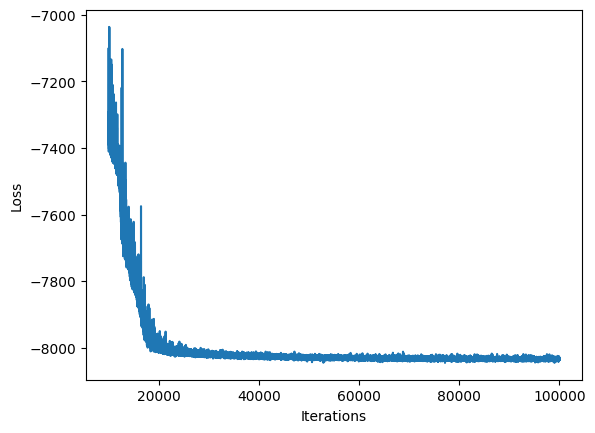

In [16]:
model.run_svi(num_steps=100000,lr=.001,resume=False)

In [12]:
model.run_mcmc()

warmup:   3%|▉                                      | 38/1500 [00:11<07:05,  3.44it/s, 255 steps of size 1.69e-03. acc. prob=0.71]


KeyboardInterrupt: 

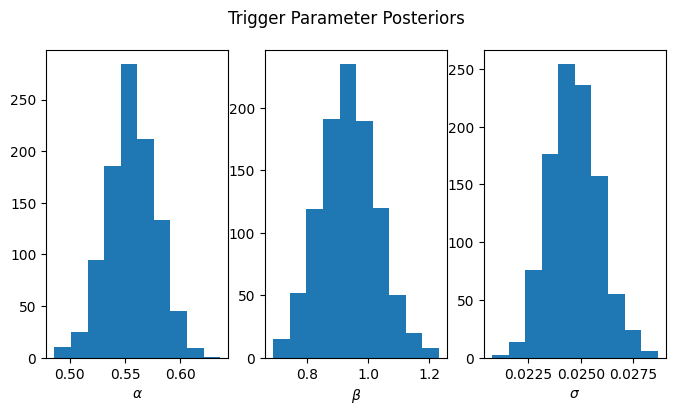

,Post Mean,Post Std,z,P>|z|,[0.025,0.975]
alpha,0.556086,0.022160,25.093712,0.0,0.513620,0.599585
beta,0.935652,0.093101,10.049908,0.0,0.757787,1.126753
sigma,0.024699,0.001198,20.616205,0.0,0.022526,0.027179


In [17]:
model.plot_trigger_posterior()

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:528: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


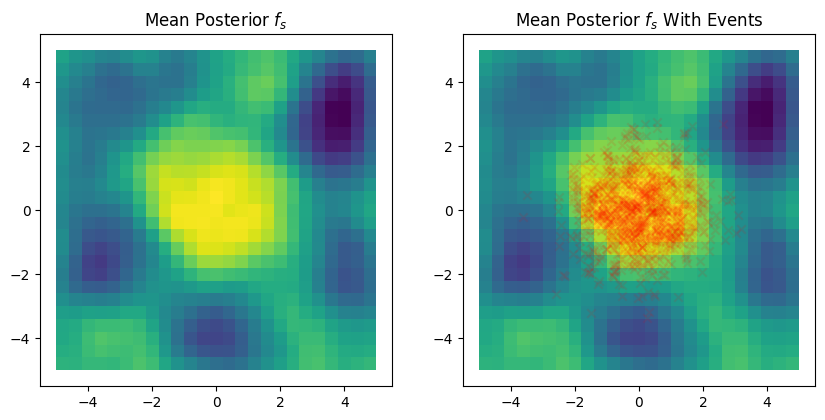

In [18]:
model.plot_spatial_background(include_cov=False)

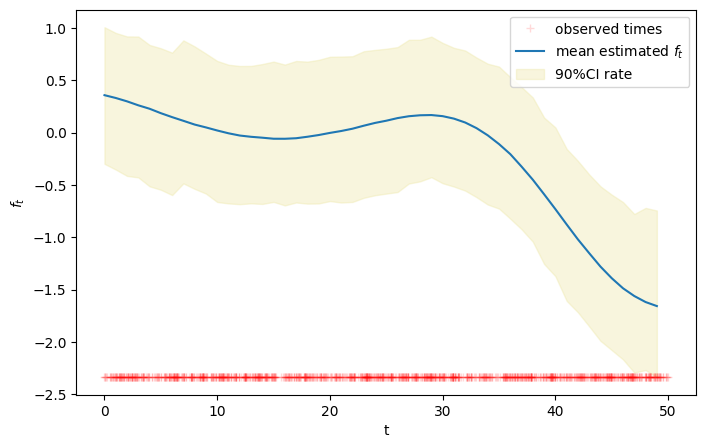

In [19]:
model.plot_temporal_background()

In [56]:
model2 = Point_Process_Model(xyt,A,'lgcp')

In [57]:
model2.run_mcmc()

sample: 100%|█████████████████████████████████████| 1500/1500 [00:15<00:00, 94.78it/s, 255 steps of size 2.02e-02. acc. prob=0.93]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a_0     -1.70      0.84     -1.69     -3.15     -0.43    450.18      1.00
  z_spatial[0]      0.58      0.08      0.58      0.45      0.71    743.20      1.00
  z_spatial[1]     -0.45      0.13     -0.44     -0.63     -0.23    535.38      1.00
  z_spatial[2]      0.30      0.07      0.30      0.20      0.42    606.76      1.00
  z_spatial[3]      0.42      0.06      0.42      0.33      0.52    408.64      1.00
  z_spatial[4]     -0.17      0.06     -0.17     -0.27     -0.07    803.80      1.00
  z_spatial[5]      0.27      0.08      0.27      0.14      0.40    476.49      1.00
  z_spatial[6]      0.73      0.07      0.73      0.61      0.85    758.40      1.00
  z_spatial[7]      0.48      0.10      0.47      0.32      0.65    521.24      1.00
  z_spatial[8]     -1.08      0.09     -1.08     -1.23     -0.94    575.46      1.00
  z_spatial[9]      0.24      0.06      0.24      0.14      0.33

/home/imanring/PointProcess/Cox_Hawkes_Cov/bstpp/main.py:528: UserWarning: `keep_geom_type=True` in overlay resulted in 3672 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersect = gpd.overlay(self.comp_grid, self.A[['geometry']], how='intersection')


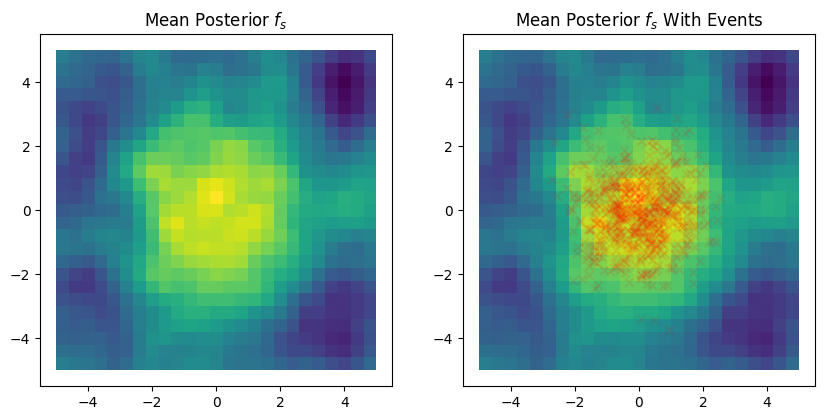

In [58]:
model2.plot_spatial_background(include_cov=False)

In [59]:
model2.mcmc_samples['f_xy'][0].min(),model2.mcmc_samples['f_xy'][0].max()

(DeviceArray(-7.040725, dtype=float32), DeviceArray(8.512199, dtype=float32))

In [60]:
model2.mcmc_samples['a_0'].mean()

DeviceArray(-1.6960607, dtype=float32)

In [61]:
model2.mcmc_samples['f_xy'][0].max()-model2.mcmc_samples['a_0'][0]

DeviceArray(11.192968, dtype=float32)

In [62]:
np.exp(model2.mcmc_samples['f_xy'][0].max()+model2.mcmc_samples['a_0'][0]+
       model2.mcmc_samples['f_t'][0].mean())

487.73495

In [63]:
def dnorm(x):
    return 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
intensity = lambda x,y: dnorm(x)*dnorm(y)*750*100/365*50

In [65]:
intensity(-5,-5),model2.mcmc_samples['f_xy'][0,0]+model2.mcmc_samples['a_0'][0]

(2.2708920364641638e-08, DeviceArray(-2.8980148, dtype=float32))

In [43]:
i,c = np.unique(model2.args['indices_xy'],return_counts=True)
i[np.argmax(c)]

287

In [46]:
np.argmax(model2.mcmc_samples['f_xy'][0]),model2.mcmc_samples['f_xy'][0,337],model2.mcmc_samples['f_xy'][0,287]

(DeviceArray(337, dtype=int32),
 DeviceArray(10.922717, dtype=float32),
 DeviceArray(9.782042, dtype=float32))

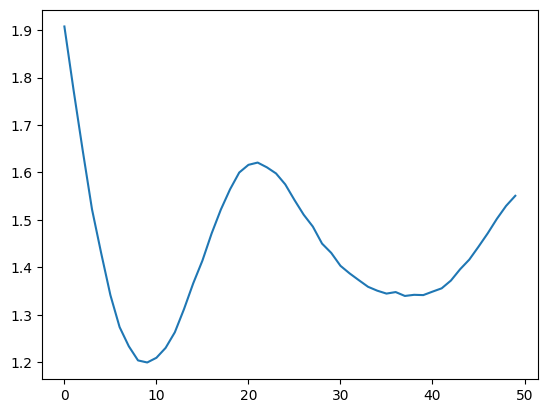

In [67]:
plt.plot(np.exp(model2.mcmc_samples['f_t'][0]))

In [32]:
model2.mcmc_samples['f_t'][0].mean()

DeviceArray(-0.9036978, dtype=float32)

In [ ]:
1.33333*